In [1]:
# Import libraries
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib

from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve,
    precision_recall_curve, average_precision_score
)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Libraries imported")

✅ Libraries imported


## 1. Load Test Data

In [2]:
project_root = Path().resolve()
processed_dir = project_root / 'data' / 'processed'
models_dir = project_root / 'models'
metrics_dir = models_dir / 'metrics'

print("Loading test data...")
X_train = pd.read_csv(processed_dir / 'X_train.csv')
X_test = pd.read_csv(processed_dir / 'X_test.csv')
y_train = pd.read_csv(processed_dir / 'y_train.csv')['label'].values
y_test = pd.read_csv(processed_dir / 'y_test.csv')['label'].values

print(f"Test set: {X_test.shape}")
print(f"Test class distribution: Benign={np.sum(y_test==0)}, Attack={np.sum(y_test==1)}")

Loading test data...
Test set: (57960, 334)
Test class distribution: Benign=55773, Attack=2187


## 2. Load All Trained Models

In [3]:
# Load all models and their metrics dynamically
models = {}
all_metrics = {}

# Scan models directory for model files
# Exclude: best_model.pkl, scaler.pkl, label_encoder.pkl, metadata files, metrics files
exclude_patterns = ['best_model', 'scaler', 'label_encoder', 'metadata', 'metrics', 'results']

print("Scanning models directory...")
model_files = [f for f in models_dir.glob('*.pkl') 
               if not any(pattern in f.stem for pattern in exclude_patterns)]

print(f"Found {len(model_files)} model files")

# Load models
print("\nLoading models...")
for model_path in sorted(model_files):
    # Extract model name from filename (e.g., 'lr_smote.pkl' -> 'LR_SMOTE')
    filename = model_path.stem  # e.g., 'lr_smote'
    
    # Convert to standard naming: lr_smote -> LR_SMOTE
    parts = filename.split('_')
    if len(parts) >= 2:
        model_prefix = parts[0].upper()  # lr -> LR, rf -> RF, xgb -> XGB, lgb -> LGB
        strategy = '_'.join(parts[1:]).title()  # smote -> Smote, weighted -> Weighted
        model_name = f"{model_prefix}_{strategy}"
    else:
        model_name = filename.upper()
    
    try:
        models[model_name] = joblib.load(model_path)
        print(f"  ✅ Loaded {model_name} ({model_path.name})")
    except Exception as e:
        print(f"  ⚠️  Failed to load {model_path.name}: {e}")

# Load metrics from models/metrics/ subfolder
print("\nLoading saved metrics...")
if metrics_dir.exists():
    metrics_files = [f for f in metrics_dir.glob('*_metrics.pkl')]
    
    for metrics_path in sorted(metrics_files):
        try:
            metrics = joblib.load(metrics_path)
            all_metrics.update(metrics)
            print(f"  ✅ Loaded {metrics_path.name}")
        except Exception as e:
            print(f"  ⚠️  Failed to load {metrics_path.name}: {e}")
else:
    print(f"  ⚠️  Metrics directory not found: {metrics_dir}")
    print("     Please run training notebooks first to generate metrics.")

print(f"\n✅ Loaded {len(models)} models")
print(f"✅ Loaded metrics for {len(all_metrics)} model variants")

Scanning models directory...
Found 14 model files

Loading models...
  ✅ Loaded LGB_Smote (lgb_smote.pkl)
  ✅ Loaded LGB_Weighted (lgb_weighted.pkl)
  ✅ Loaded LR_Smote (lr_smote.pkl)
  ✅ Loaded LR_Weighted (lr_weighted.pkl)
  ✅ Loaded MLP_Smote (mlp_smote.pkl)
  ✅ Loaded MLP_Weighted (mlp_weighted.pkl)
  ✅ Loaded NB_Smote (nb_smote.pkl)
  ✅ Loaded NB_Weighted (nb_weighted.pkl)
  ✅ Loaded RF_Smote (rf_smote.pkl)
  ✅ Loaded RF_Weighted (rf_weighted.pkl)
  ✅ Loaded SVM_Smote (svm_smote.pkl)
  ✅ Loaded SVM_Weighted (svm_weighted.pkl)
  ✅ Loaded XGB_Smote (xgb_smote.pkl)
  ✅ Loaded XGB_Weighted (xgb_weighted.pkl)

Loading saved metrics...
  ✅ Loaded lgb_metrics.pkl
  ✅ Loaded lr_metrics.pkl
  ✅ Loaded mlp_metrics.pkl
  ✅ Loaded nb_metrics.pkl
  ✅ Loaded rf_metrics.pkl
  ✅ Loaded svm_metrics.pkl
  ✅ Loaded xgb_metrics.pkl

✅ Loaded 14 models
✅ Loaded metrics for 14 model variants


## 3. Comprehensive Metrics Comparison

In [4]:
# Create comparison DataFrame
results_df = pd.DataFrame(all_metrics).T

# Add strategy and model columns
results_df['strategy'] = results_df.index.str.extract(r'_(Smote|Weighted)')[0]
results_df['model'] = results_df.index.str.extract(r'(LR|RF|XGB|LGB|SVM|MLP|NB)_')[0]

# Sort by PR-AUC (most important metric for imbalanced data)
results_df = results_df.sort_values('pr_auc', ascending=False)

print("="*80)
print("MODEL COMPARISON - Sorted by PR-AUC")
print("="*80)
print(results_df[['model', 'strategy', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc', 'train_time']].to_string())
print("="*80)

MODEL COMPARISON - Sorted by PR-AUC
             model strategy  accuracy  precision    recall        f1   roc_auc    pr_auc  train_time
LGB_SMOTE      NaN      NaN  0.999983   0.999543  1.000000  0.999771  1.000000  1.000000    6.331925
MLP_SMOTE      NaN      NaN  0.999983   0.999543  1.000000  0.999771  1.000000  1.000000   11.992576
MLP_Weighted   NaN      NaN  0.999983   0.999543  1.000000  0.999771  1.000000  1.000000    4.928781
SVM_Weighted   NaN      NaN  0.999983   0.999543  1.000000  0.999771  1.000000  1.000000  201.218991
LR_Weighted    NaN      NaN  0.999948   0.998630  1.000000  0.999315  1.000000  1.000000    4.464593
RF_SMOTE       NaN      NaN  0.996032   0.904841  1.000000  0.950043  1.000000  1.000000    8.553986
SVM_SMOTE      NaN      NaN  0.999983   0.999543  1.000000  0.999771  1.000000  1.000000   48.066141
XGB_Weighted   NaN      NaN  0.999965   0.999086  1.000000  0.999543  1.000000  1.000000    2.714893
XGB_SMOTE      NaN      NaN  0.999965   0.999086  1.000

In [5]:
# Summary statistics by strategy
print("\n" + "="*80)
print("AVERAGE PERFORMANCE BY STRATEGY")
print("="*80)
strategy_summary = results_df.groupby('strategy')[['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']].mean()
print(strategy_summary.to_string())
print("="*80)

# Summary statistics by model family
print("\n" + "="*80)
print("AVERAGE PERFORMANCE BY MODEL FAMILY")
print("="*80)
model_summary = results_df.groupby('model')[['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']].mean()
print(model_summary.to_string())
print("="*80)


AVERAGE PERFORMANCE BY STRATEGY
Empty DataFrame
Columns: [accuracy, precision, recall, f1, roc_auc, pr_auc]
Index: []

AVERAGE PERFORMANCE BY MODEL FAMILY
Empty DataFrame
Columns: [accuracy, precision, recall, f1, roc_auc, pr_auc]
Index: []


## 4. Visualizations

### 4.1 Metrics Comparison Bar Charts

ValueError: Index contains duplicate entries, cannot reshape

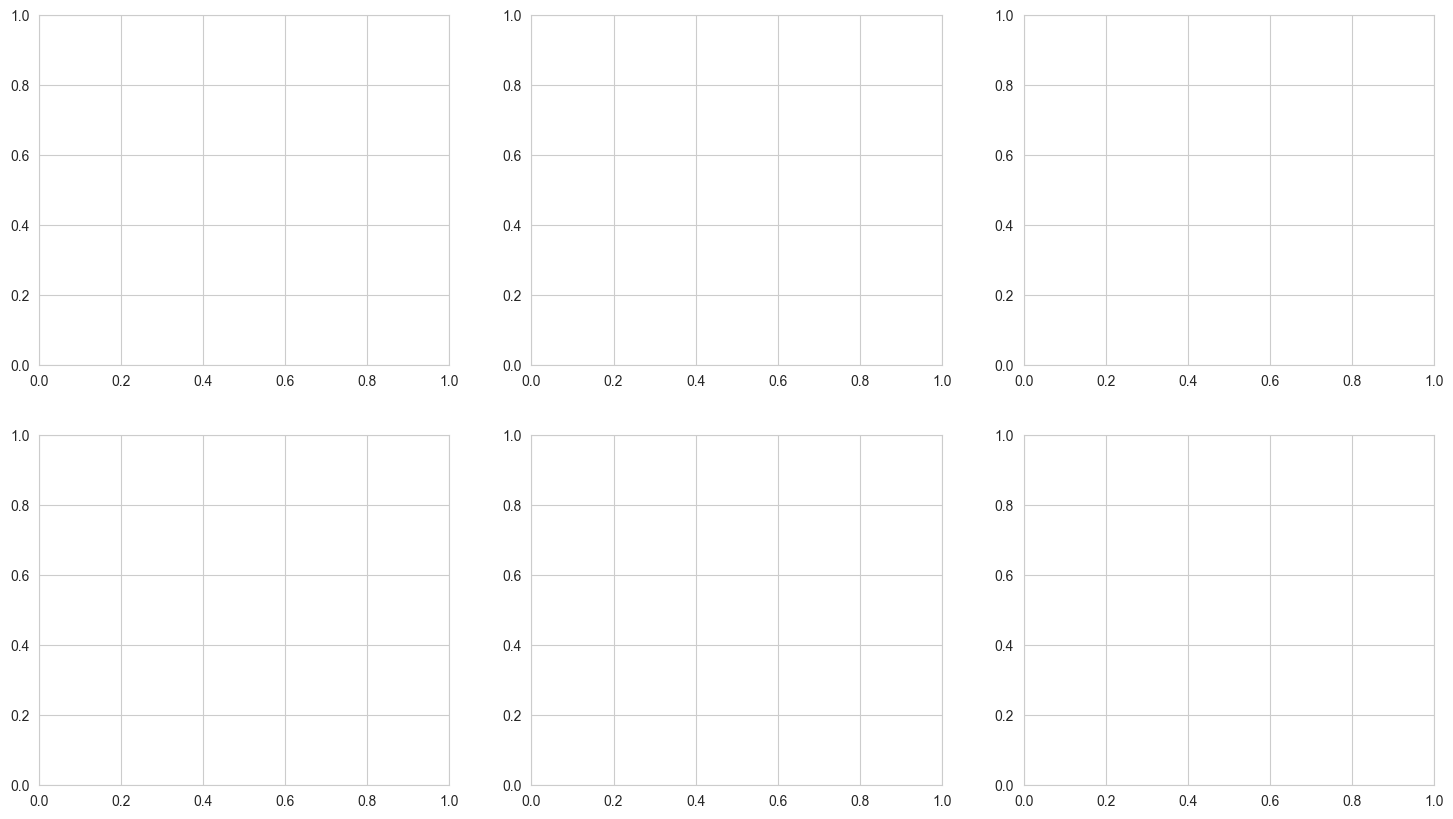

In [6]:
# Visualize model comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']
colors = {'SMOTE': 'steelblue', 'Weighted': 'orange'}

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    
    # Group by model and strategy
    pivot_data = results_df.pivot(index='model', columns='strategy', values=metric)
    
    pivot_data.plot(kind='bar', ax=ax, color=[colors.get(col, 'gray') for col in pivot_data.columns])
    
    ax.set_ylabel(metric.upper())
    ax.set_title(f'{metric.upper()} by Model and Strategy')
    ax.set_xlabel('')
    ax.legend(title='Strategy')
    ax.set_ylim([0, 1.05])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', fontsize=8)

plt.tight_layout()
plt.savefig(models_dir / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: models/model_comparison.png")

### 4.2 Precision-Recall Curves

In [ ]:
# Plot PR curves for all models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# SMOTE models
ax = axes[0]
for model_name in models.keys():
    if 'SMOTE' in model_name and model_name in models:
        model = models[model_name]
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = average_precision_score(y_test, y_pred_proba)
        
        label = model_name.replace('_SMOTE', '')
        ax.plot(recall, precision, linewidth=2, label=f'{label} (AP={pr_auc:.4f})')

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves - SMOTE Strategy', fontsize=14)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Weighted models
ax = axes[1]
for model_name in models.keys():
    if 'Weighted' in model_name and model_name in models:
        model = models[model_name]
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = average_precision_score(y_test, y_pred_proba)
        
        label = model_name.replace('_Weighted', '')
        ax.plot(recall, precision, linewidth=2, label=f'{label} (AP={pr_auc:.4f})')

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves - Class Weight Strategy', fontsize=14)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(models_dir / 'pr_curves_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: models/pr_curves_all_models.png")
print("\n💡 KEY INSIGHT: PR-AUC is the most important metric for imbalanced data!")

### 4.3 ROC Curves

In [ ]:
# Plot ROC curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# SMOTE models
ax = axes[0]
for model_name in models.keys():
    if 'SMOTE' in model_name and model_name in models:
        model = models[model_name]
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        
        from sklearn.metrics import roc_auc_score
        auc_score = roc_auc_score(y_test, y_pred_proba)
        
        label = model_name.replace('_SMOTE', '')
        ax.plot(fpr, tpr, linewidth=2, label=f'{label} (AUC={auc_score:.4f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - SMOTE Strategy', fontsize=14)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Weighted models
ax = axes[1]
for model_name in models.keys():
    if 'Weighted' in model_name and model_name in models:
        model = models[model_name]
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        
        auc_score = roc_auc_score(y_test, y_pred_proba)
        
        label = model_name.replace('_Weighted', '')
        ax.plot(fpr, tpr, linewidth=2, label=f'{label} (AUC={auc_score:.4f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - Class Weight Strategy', fontsize=14)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(models_dir / 'roc_curves_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: models/roc_curves_all_models.png")

## 5. Select Best Model

In [ ]:
# Identify best models by different criteria
best_by_pr_auc = results_df['pr_auc'].idxmax()
best_by_f1 = results_df['f1'].idxmax()
best_by_recall = results_df['recall'].idxmax()

print("="*80)
print("BEST MODELS BY DIFFERENT CRITERIA")
print("="*80)

print(f"\n🏆 Best by PR-AUC (Recommended): {best_by_pr_auc}")
print(f"   PR-AUC: {results_df.loc[best_by_pr_auc, 'pr_auc']:.4f}")
print(f"   F1: {results_df.loc[best_by_pr_auc, 'f1']:.4f}")
print(f"   Precision: {results_df.loc[best_by_pr_auc, 'precision']:.4f}")
print(f"   Recall: {results_df.loc[best_by_pr_auc, 'recall']:.4f}")

print(f"\n🥈 Best by F1 Score: {best_by_f1}")
print(f"   F1: {results_df.loc[best_by_f1, 'f1']:.4f}")
print(f"   PR-AUC: {results_df.loc[best_by_f1, 'pr_auc']:.4f}")

print(f"\n🥉 Best by Recall (Catches Most Attacks): {best_by_recall}")
print(f"   Recall: {results_df.loc[best_by_recall, 'recall']:.4f}")
print(f"   Precision: {results_df.loc[best_by_recall, 'precision']:.4f}")

print("="*80)

# Select best model (using PR-AUC as primary criterion)
best_model_name = best_by_pr_auc
best_model = models[best_model_name]

print(f"\n✅ SELECTED MODEL: {best_model_name}")
print(f"   (Based on PR-AUC - best metric for imbalanced classification)")
print("="*80)

## 6. Best Model Analysis

### 6.1 Confusion Matrix

In [ ]:
# Get predictions from best model
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
tn, fp, fn, tp = cm.ravel()

# Calculate rates
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Attack'],
            yticklabels=['Benign', 'Attack'],
            cbar_kws={'label': 'Count'}, annot_kws={'size': 16})
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16)
plt.savefig(models_dir / 'best_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("="*80)
print("CONFUSION MATRIX ANALYSIS")
print("="*80)
print(f"True Negatives (TN):  {tn:,} - Correctly identified benign traffic")
print(f"False Positives (FP): {fp:,} - Benign traffic flagged as attack (False Alarms)")
print(f"False Negatives (FN): {fn:,} - Attacks missed (⚠️ CRITICAL!)")
print(f"True Positives (TP):  {tp:,} - Correctly detected attacks")
print(f"\nFalse Positive Rate:  {fpr:.4f} ({fpr*100:.2f}%)")
print(f"False Negative Rate:  {fnr:.4f} ({fnr*100:.2f}%)")
print("="*80)

if fnr > 0.1:
    print("\n⚠️  WARNING: High False Negative Rate - Missing >10% of attacks!")
if fpr > 0.05:
    print("⚠️  WARNING: High False Positive Rate - May generate too many false alarms!")

print("✅ Saved: models/best_model_confusion_matrix.png")

### 6.2 Classification Report

In [ ]:
print("\n" + "="*80)
print("CLASSIFICATION REPORT - Best Model")
print("="*80)
print(classification_report(y_test, y_pred_best, target_names=['Benign', 'Attack']))
print("="*80)

### 6.3 Feature Importance (Tree-based models only)

In [ ]:
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(10, 10))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance', fontsize=12)
    plt.title(f'Top 20 Feature Importances - {best_model_name}', fontsize=14)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(models_dir / 'best_model_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))
    print("\n✅ Saved: models/best_model_feature_importance.png")
else:
    print(f"\n⚠️  {best_model_name} does not have feature_importances_ attribute")

## 7. Save Best Model

In [ ]:
# Delete old best_model.pkl to avoid conflicts
old_model_path = models_dir / 'best_model.pkl'
if old_model_path.exists():
    print(f"Removing old best model: {old_model_path}")
    old_model_path.unlink()

# Save best model
best_model_path = models_dir / 'best_model.pkl'
joblib.dump(best_model, best_model_path)
print(f"\n✅ Best model saved to: {best_model_path}")

# Save comprehensive metadata
metadata = {
    'model_name': best_model_name,
    'model_type': type(best_model).__name__,
    'strategy': results_df.loc[best_model_name, 'strategy'],
    'metrics': all_metrics[best_model_name],
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'original_class_distribution': {
        'benign': int(np.sum(y_train == 0)),
        'attack': int(np.sum(y_train == 1)),
        'imbalance_ratio': float(np.sum(y_train == 0) / np.sum(y_train == 1))
    },
    'features': list(X_train.columns),
    'n_features': len(X_train.columns),
    'confusion_matrix': {
        'tn': int(tn),
        'fp': int(fp),
        'fn': int(fn),
        'tp': int(tp),
        'fpr': float(fpr),
        'fnr': float(fnr)
    },
    'all_models_compared': len(models),
    'ranking': {
        'best_pr_auc': best_by_pr_auc,
        'best_f1': best_by_f1,
        'best_recall': best_by_recall
    }
}

metadata_path = models_dir / 'best_model_metadata.pkl'
joblib.dump(metadata, metadata_path)
print(f"✅ Metadata saved to: {metadata_path}")

# Save comparison results
results_path = models_dir / 'all_model_results.csv'
results_df.to_csv(results_path)
print(f"✅ Comparison results saved to: {results_path}")

## 8. Final Summary and Recommendations

In [ ]:
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

print(f"\nModels Trained and Compared: {len(models)}")
print(f"  SMOTE models: {len([m for m in models if 'SMOTE' in m])}")
print(f"  Class Weight models: {len([m for m in models if 'Weighted' in m])}")

print(f"\n🏆 SELECTED BEST MODEL: {best_model_name}")
print(f"   Model Type: {type(best_model).__name__}")
print(f"   Strategy: {results_df.loc[best_model_name, 'strategy']}")

print(f"\n📊 Performance Metrics:")
print(f"   Accuracy:  {results_df.loc[best_model_name, 'accuracy']:.4f}")
print(f"   Precision: {results_df.loc[best_model_name, 'precision']:.4f}")
print(f"   Recall:    {results_df.loc[best_model_name, 'recall']:.4f}")
print(f"   F1 Score:  {results_df.loc[best_model_name, 'f1']:.4f}")
print(f"   ROC-AUC:   {results_df.loc[best_model_name, 'roc_auc']:.4f}")
print(f"   PR-AUC:    {results_df.loc[best_model_name, 'pr_auc']:.4f} ⭐ (Key metric)")

print(f"\n🎯 Confusion Matrix:")
print(f"   Attacks Detected:    {tp:,} ({tp/(tp+fn)*100:.1f}% of all attacks)")
print(f"   Attacks Missed:      {fn:,} ({fnr*100:.1f}%)")
print(f"   False Alarms:        {fp:,} ({fpr*100:.1f}% of benign traffic)")
print(f"   Correct Benign:      {tn:,}")

print(f"\n💾 Saved Files:")
print(f"   - {best_model_path.name}")
print(f"   - {metadata_path.name}")
print(f"   - model_comparison.png")
print(f"   - pr_curves_all_models.png")
print(f"   - roc_curves_all_models.png")
print(f"   - best_model_confusion_matrix.png")
if hasattr(best_model, 'feature_importances_'):
    print(f"   - best_model_feature_importance.png")

print("\n" + "="*80)
print("💡 RECOMMENDATIONS")
print("="*80)

# Strategy recommendation
smote_avg = results_df[results_df['strategy'] == 'SMOTE']['pr_auc'].mean()
weighted_avg = results_df[results_df['strategy'] == 'Weighted']['pr_auc'].mean()

if weighted_avg > smote_avg * 1.02:  # 2% better
    print("\n✅ Class Weight strategy is RECOMMENDED:")
    print("   - Better average PR-AUC across all models")
    print("   - Preserves real-world class distribution")
    print("   - Lower false positive rate (fewer false alarms)")
    print("   - Faster training (no synthetic data generation)")
elif smote_avg > weighted_avg * 1.02:
    print("\n✅ SMOTE strategy is RECOMMENDED:")
    print("   - Better average PR-AUC across all models")
    print("   - Better recall (catches more attacks)")
    print("   - Worth the trade-off for security applications")
else:
    print("\n✅ Both strategies perform SIMILARLY:")
    print("   - Consider Class Weights for production (faster, preserves distribution)")
    print("   - Consider SMOTE if recall is critical")

# Model family recommendation
best_family = results_df.groupby('model')['pr_auc'].mean().idxmax()
print(f"\n🏆 Best Model Family: {best_family}")
print(f"   Average PR-AUC: {results_df.groupby('model')['pr_auc'].mean()[best_family]:.4f}")

print("\n" + "="*80)
print("✅ MODEL COMPARISON COMPLETE")
print("="*80)
print(f"\nReady for deployment: {best_model_path}")
print("View MLflow UI: mlflow ui")
print("="*80)

## Next Steps

### Production Deployment
1. **Integrate with API**: Load `best_model.pkl` in `src/api/main.py`
2. **Inference Pipeline**: Use in `src/inference_pipeline/predict.py`
3. **Dashboard**: Visualize predictions in `app.py` Streamlit dashboard
4. **Monitoring**: Track prediction distribution and performance drift

### Model Improvement
5. **Hyperparameter Tuning**: Use GridSearchCV or Optuna on best model family
6. **Feature Selection**: Try removing low-importance features
7. **Ensemble**: Combine top 3 models for potentially better performance
8. **Threshold Optimization**: Adjust decision threshold based on FP/FN costs
9. **Cross-Validation**: Perform k-fold CV for more robust evaluation

### Key Takeaways
- **PR-AUC > ROC-AUC** for imbalanced data
- **Tree-based models** (RF, XGB, LGB) typically outperform linear models
- **Class weights vs SMOTE**: Both work, but class weights often better in production
- **False negatives** (missed attacks) are usually more costly than false positives
- **Monitor in production**: Model performance may drift over time